Standard dataset preprocessed and saved to /content/sample_data/Output/preprocessed_FTP Standard_Synthetic_v1.xlsx
Synthetic dataset preprocessed and saved to /content/sample_data/Output/preprocessed_FTP Standard_Synthetic_v1.xlsx
Synthetic dataset preprocessed and saved to /content/sample_data/Output/preprocessed_FTP Standard_Synthetic_v2.xlsx
Synthetic dataset preprocessed and saved to /content/sample_data/Output/preprocessed_FTP Standard_Synthetic_v4.xlsx
Synthetic dataset preprocessed and saved to /content/sample_data/Output/preprocessed_FTP Standard_Synthetic_v3.xlsx
Synthetic dataset preprocessed and saved to /content/sample_data/Output/preprocessed_FTP Standard_Synthetic_v5.xlsx
Combined dataset saved to /content/sample_data/Output/combined_preprocessed_dataset.xlsx
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0313 - val_loss: 0.0026
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - val_loss: 9.7003e-04
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.6865e-04 - val_loss: 9.0590e-04
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.4800e-04 - val_loss: 9.4181e-04
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.4133e-04 - val_loss: 9.7212e-04
Epoch 12/50
235/235 ━━━━━━━━━━━

Mean Squared Error on Test Data: 0.0008265481446869671
Model training completed and saved as 'velocity_prediction_model.h5'
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


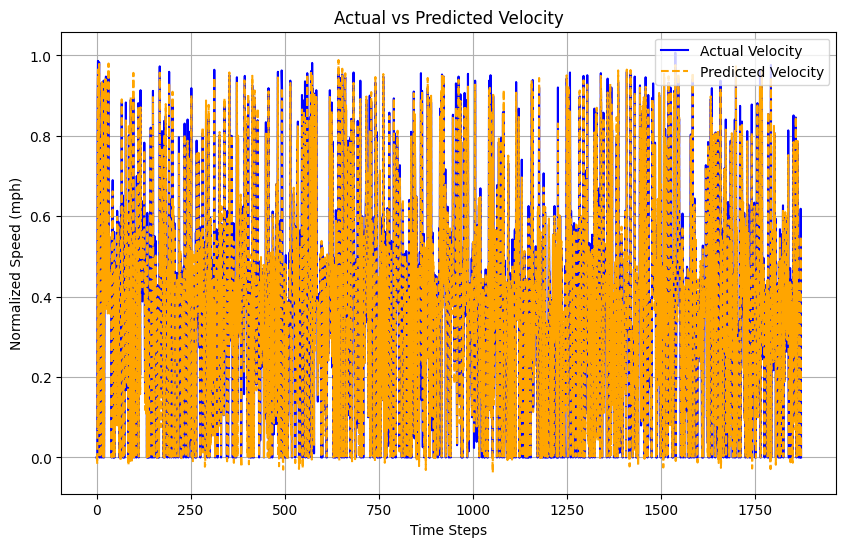

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def preprocess_dataset(file_path, scaler=None):
    data = pd.read_excel(file_path)
    time = data['Test Time, secs'].values.reshape(-1, 1)
    speed = data['Target Speed, mph'].values.reshape(-1, 1)

    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        speed = scaler.fit_transform(speed)
    else:
        speed = scaler.transform(speed)

    preprocessed_data = pd.DataFrame({
        'Test Time, secs': time.flatten(),
        'Target Speed, mph': speed.flatten()
    })

    return preprocessed_data, scaler

def find_standard_file(all_files):
    standard_files = [f for f in all_files if 'standard' in f.lower()]
    if not standard_files:
        raise ValueError("No standard file found in the input folder.")
    return standard_files[0]

input_folder = '/content/sample_data/Input/Standard'
output_folder = '/content/sample_data/Output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scaler = MinMaxScaler(feature_range=(0, 1))
all_files = [f for f in os.listdir(input_folder) if f.endswith('.xlsx')]

standard_file = find_standard_file(all_files)
file_path = os.path.join(input_folder, standard_file)
data = pd.read_excel(file_path)
speed = data['Target Speed, mph'].values.reshape(-1, 1)
scaler.fit(speed)

preprocessed_data, scaler = preprocess_dataset(file_path, scaler)
preprocessed_file_path = os.path.join(output_folder, f'preprocessed_{standard_file}')
preprocessed_data.to_excel(preprocessed_file_path, index=False)
print(f"Standard dataset preprocessed and saved to {preprocessed_file_path}")

synthetic_files = [f for f in all_files if 'synthetic' in f.lower()]
for file_name in synthetic_files:
    file_path = os.path.join(input_folder, file_name)
    preprocessed_data, _ = preprocess_dataset(file_path, scaler)
    preprocessed_file_path = os.path.join(output_folder, f'preprocessed_{file_name}')
    preprocessed_data.to_excel(preprocessed_file_path, index=False)
    print(f"Synthetic dataset preprocessed and saved to {preprocessed_file_path}")

combined_data = pd.DataFrame()
preprocessed_files = [f for f in os.listdir(output_folder) if f.endswith('.xlsx')]
for file_name in preprocessed_files:
    file_path = os.path.join(output_folder, file_name)
    data = pd.read_excel(file_path)
    combined_data = pd.concat([combined_data, data], axis=0)

combined_file_path = os.path.join(output_folder, 'combined_preprocessed_dataset.xlsx')
combined_data.to_excel(combined_file_path, index=False)
print(f"Combined dataset saved to {combined_file_path}")

speed_data = combined_data['Target Speed, mph'].values
n_steps = 10

def create_time_series_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

X, y = create_time_series_data(speed_data, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on Test Data: {mse}")

model.save('/content/velocity_prediction_model.h5')
print("Model training completed and saved as 'velocity_prediction_model.h5'")

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Velocity', color='blue')
plt.plot(y_pred, label='Predicted Velocity', color='orange', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Speed (mph)')
plt.title('Actual vs Predicted Velocity')
plt.legend()
plt.grid(True)
plt.show()

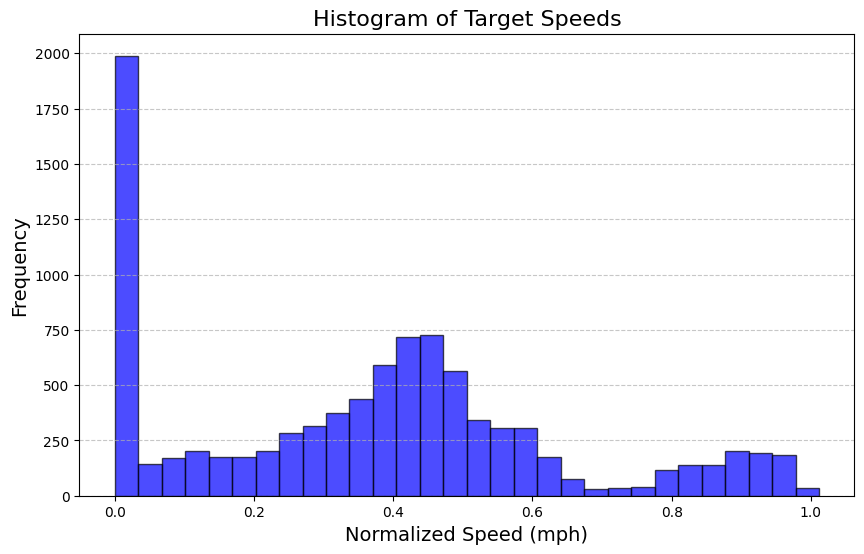

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'speed_data' is the array containing the speed values
plt.figure(figsize=(10, 6))
plt.hist(speed_data, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Target Speeds', fontsize=16)
plt.xlabel('Normalized Speed (mph)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
